## Getting Started with Badfish - A library for missing data

For the purposes of this tutorial, I am using R's Airquality dataset. (Attach Link). 

Let's do a quick import to get started.

In [1]:
import pandas as pd
import badfish as bf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data/airquality.csv', index_col=0)

We need to convert the Pandas dataframe to Badfish's missframe.

In [3]:
mf = bf.MissFrame(df)

A MissFrame converts your data to a boolean matrix where a missing cell indicates a True value while a filled cell is given a False value.

What are the different functions that can be used with the MissFrame?

In [4]:
dir(mf)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_masked_missframe',
 'cohort',
 'corr',
 'counts',
 'data',
 'frequency_item_set',
 'get_best_column_set',
 'miss_frame',
 'pattern',
 'plot']

Lets quickly use Pandas isnull().sum() function to check how many missing values are present in the different columns.

In [5]:
df.isnull().sum()

Ozone      37
Solar.R     7
Wind        4
Temp       14
Month       0
Day         0
dtype: int64

All MissFrame methods contain the same structure of arguments.

1. **Where** - Show me data where '_____' are missing.
2. **How** - Show me data where '_____' columns are ALL/ANY missing
3. **Columns** - Show me description for only '_____' columns

We can replicate the same functionality of counting the missing values with mf.counts()

In [6]:
mf.counts()

Ozone      37
Temp       14
Solar.R     7
Wind        4
Day         0
Month       0
dtype: int64

Now let's make our query a tad more complicated.

What if I wanted to see how many data-cells of Solar,Temp and Wind are missing when Ozone is missing?
This gives an idea on how the missing data on **one** (or more) column **affects other columns.**

In [7]:
mf.counts(where = ['Ozone'],how = 'any',columns=['Solar.R','Wind','Temp'])

Temp       8
Wind       2
Solar.R    2
dtype: int64

Okay, so we've got 8 missing cells of Temp, 2 of Wind and Solar each when Ozone goes missing.

What happens when Ozone **OR** temp go missing? How does it affect the other three?

In [8]:
mf.counts(where=['Ozone','Temp'], how='any', columns=['Solar.R','Wind','Temp'])

Temp       14
Wind        2
Solar.R     2
dtype: int64

The **how = 'any'** or **how = 'all'** controls how the columns are used.

If you want to see the number of missing cell counts in rows where Ozone **AND** temp go missing- 

In [9]:
mf.counts(where = ['Ozone','Temp'],how = 'all',columns=['Solar.R','Wind','Temp'])

Temp       8
Wind       0
Solar.R    0
dtype: int64

The pattern plot below gives a nice understanding of the amount of data missing with different combinations of samples. Blue tiles indicate the presence of data whereas red tiles indicate missing data. 

We see that Ozone has the highest amount of missing data (27 samples) where-as 8 samples are missing a combination of Ozone and Temp data.

Note- The raw counts are given on the left.

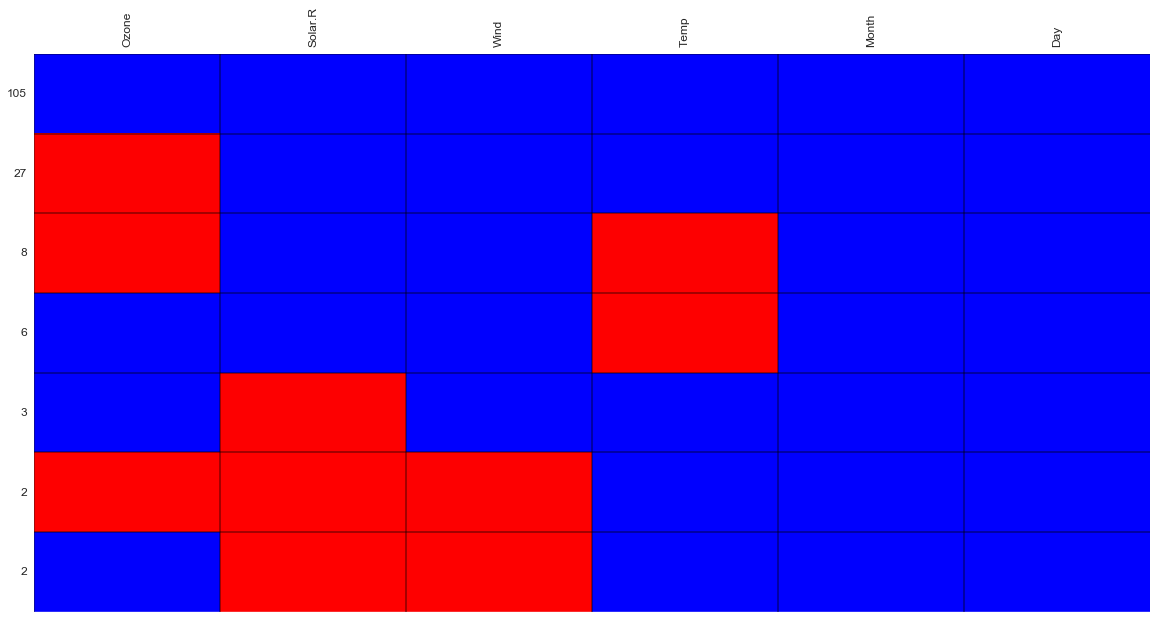

In [10]:
mf.plot(kind='pattern', norm = False, threshold=0.0)

In [11]:
mf.pattern(columns = ['Ozone', 'Temp', 'Solar.R'], norm = False, threshold=0.0)

,Ozone,Temp,Solar.R,0
0,False,False,False,105
1,True,False,False,27
2,True,True,False,8
3,False,True,False,6
4,False,False,True,5
5,True,False,True,2


A tabular function to show which columns seem to go missing together reports these correlations of missing data-

In [12]:
mf.corr(columns = ['Ozone', 'Temp','Wind'])

,Ozone,Temp,Wind
Ozone,1.000000,0.244289,0.098788
Temp,0.244289,1.000000,-0.051999
Wind,0.098788,-0.051999,1.000000


Or perhaps let's look at only the correlations of missing data of other columns with Ozone:

In [13]:
mf.corr()['Ozone']

Ozone      1.000000
Solar.R    0.022441
Wind       0.098788
Temp       0.244289
Month           NaN
Day             NaN
Name: Ozone, dtype: float64

One of the well known datamining techniques is **Association Rule Algorithm**. Priori to the association rule generation, frequent itemsets are generated based on the item-item relations from the large data set according to a certain support. 

Thus the frequent itemsets of a data set represent strong correlations between different items, and the itemsets represent probabilities for one or more items existing together in the current transaction. If we use the different columns as items, we could find which columns go missing together and generate possibly causal association rules.

In [14]:
mf.frequency_item_set?

In [15]:
itemsets, rules = mf.frequency_item_set(columns = ['Ozone','Temp','Wind'], support=0.01, confidence=0.0)

C:\Anaconda3\lib\site-packages\pandas\indexes\base.py:1275: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  result = getitem(key)


In [16]:
itemsets

,Itemset,Support
0,"[Ozone, Wind]",2
1,"[Ozone, Temp]",8
2,[Wind],4
3,[Ozone],37
4,[Temp],14


In [17]:
rules

,X =>,Y,Support,Confidence
0,[Wind],[Ozone],2,0.500000
1,[Ozone],[Wind],2,0.054054
2,[Temp],[Ozone],8,0.571429
3,[Ozone],[Temp],8,0.216216


In [18]:
mf.cohort(group = ['Ozone'])

,Column,Non-null values in Group (missing),Non-null values in Group (non-missing),Mean - Group (missing),Mean - Group (non-missing),T (Equal Variance),p value (Equal Variance),T (Unequal Variance),p value (Unequal Variance)
0,Ozone,0,116,NaN,42.129310,--,--,--,--
1,Solar.R,35,111,189.514286,184.801802,0.269061,0.788268,0.274568,0.784608
2,Wind,35,114,10.205714,9.843860,0.531228,0.596062,0.545515,0.587458
3,Temp,29,110,78.137931,78.072727,0.031654,0.974794,0.0296486,0.976493
